Using device: cuda


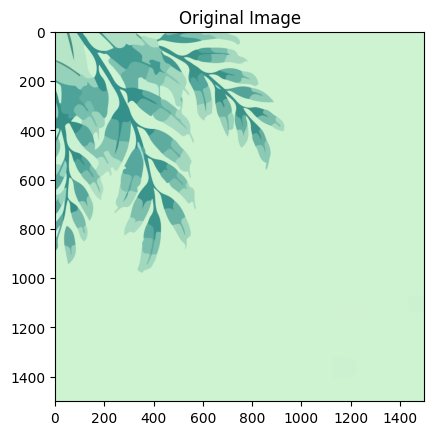

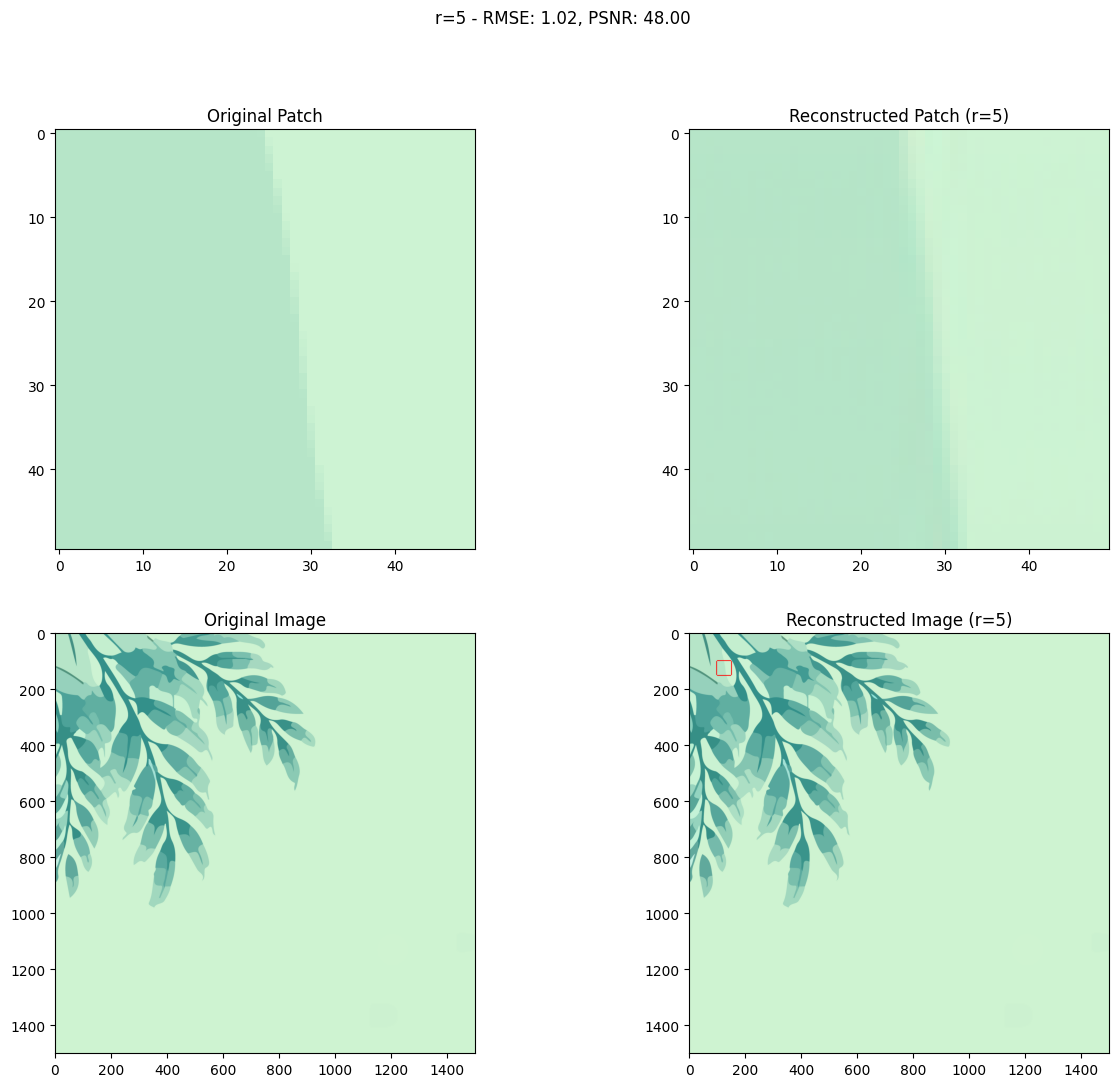

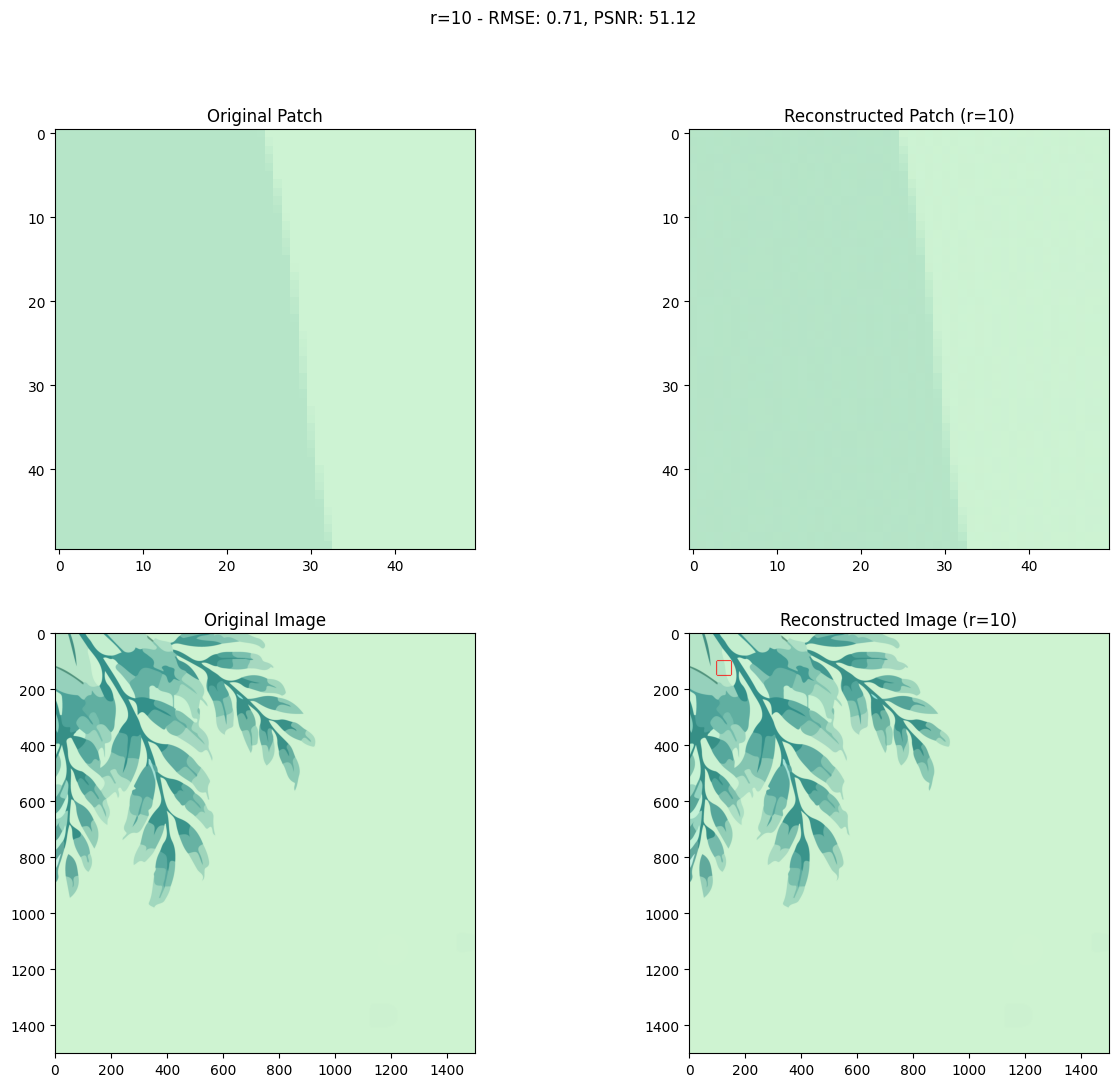

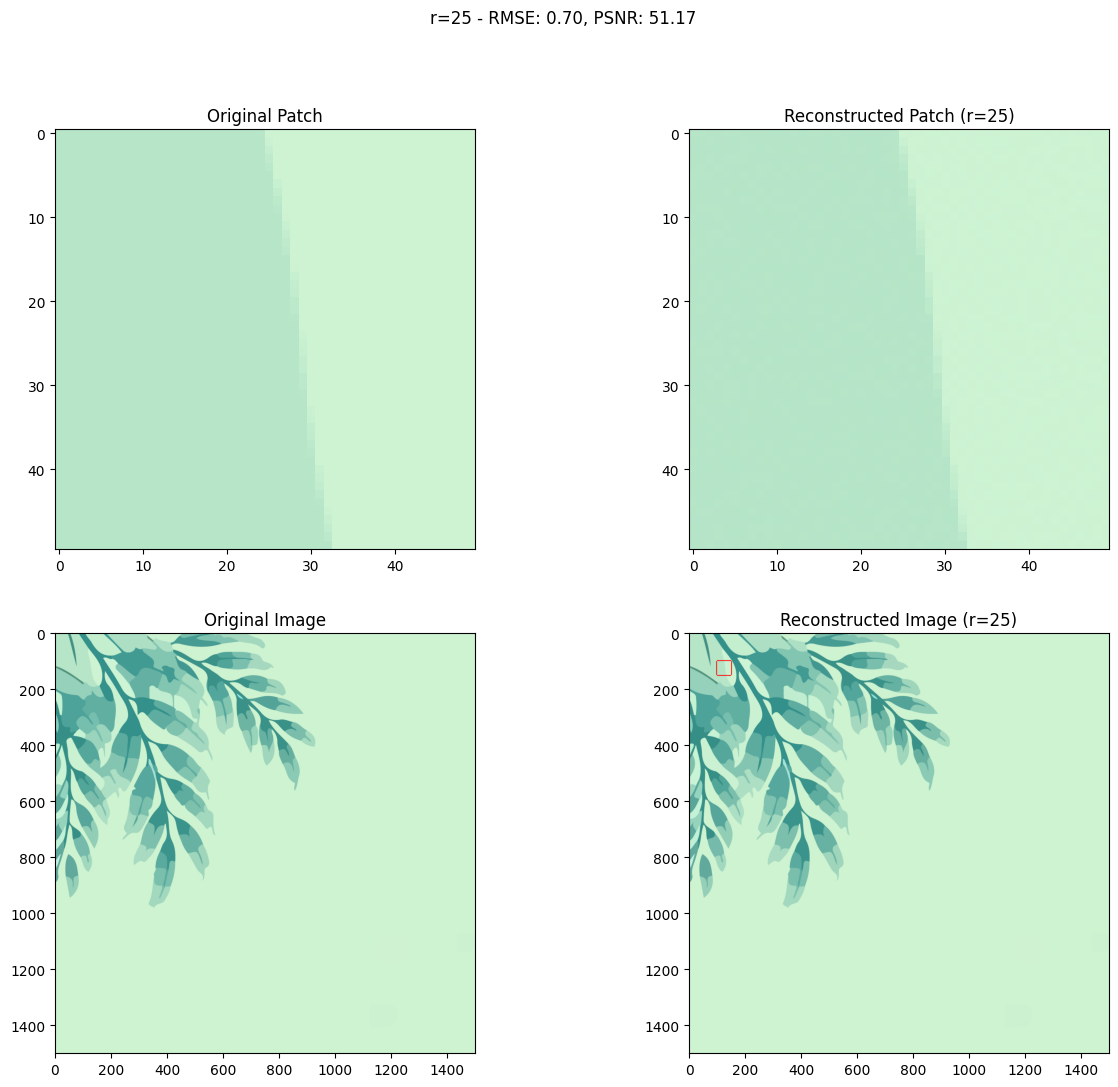

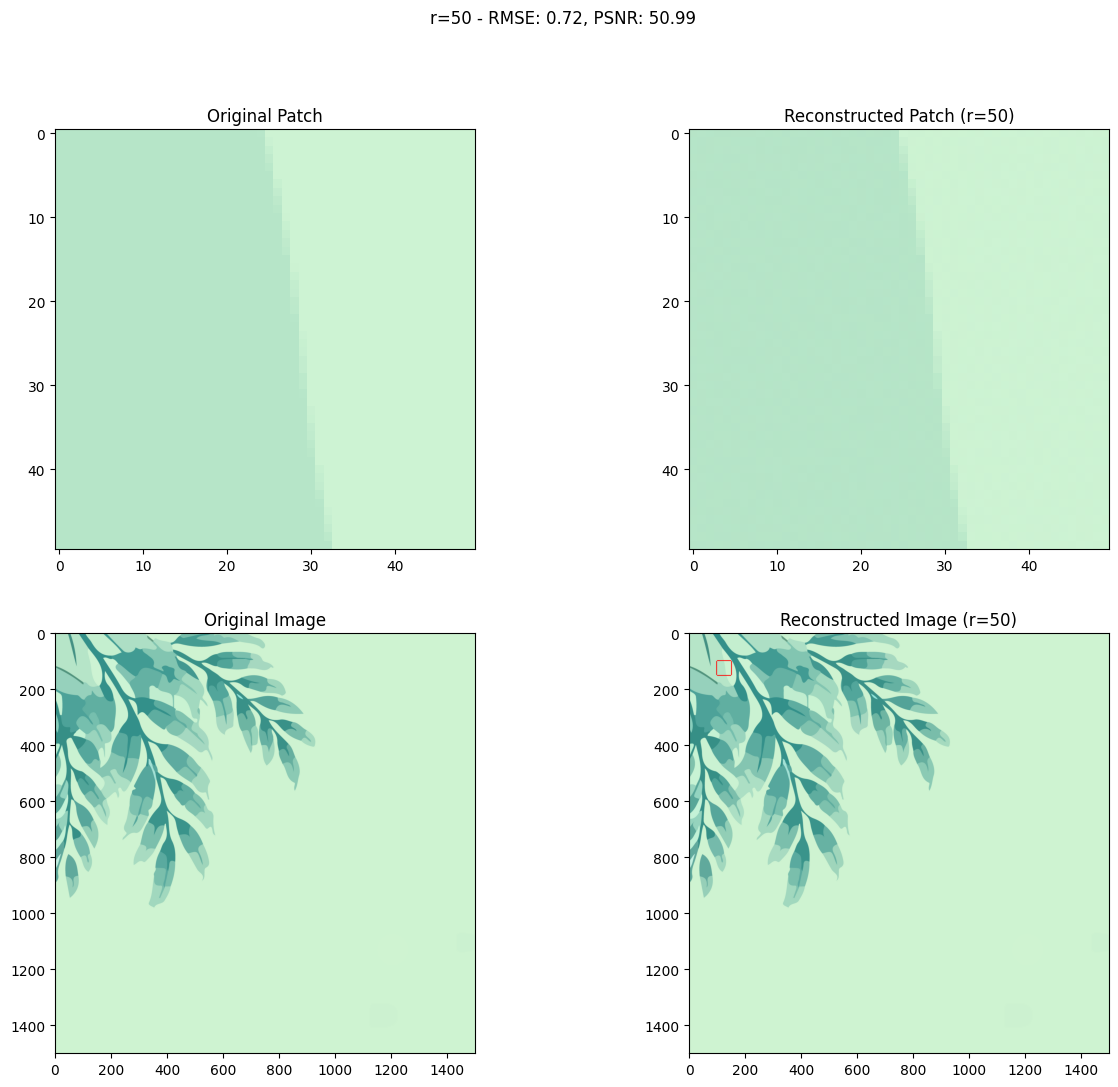

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from skimage import io, color

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load and preprocess the image
image_path = '/kaggle/input/tree-img/Design project report template.png'  
image = io.imread(image_path)

# Check if the image has an alpha channel and remove it
if image.shape[2] == 4:  # RGBA
    image = image[:, :, :3]  # Keep only RGB channels
    
# Crop the image to 1500x1500
image = image[:1500, :1500, :]

plt.title('Original Image')
plt.imshow(image.astype(np.uint8))
plt.axis('on')

# Extract a 50x50 patch from the image
x, y, size = 100, 100, 50  
patch = image[x:x+size, y:y+size, :]

# Convert the patch to a PyTorch tensor
patch_tensor = torch.tensor(patch, dtype=torch.float32).to(device)

# Set parameters for matrix factorization
r_values = [5, 10, 25, 50]
learning_rate = 1e-3
epochs = 20000

# Loop through different values of r
for r in r_values:
    reconstructed_np = np.zeros_like(patch)  # Initialize the reconstructed image

    for c in range(3):  # Loop over RGB channels
        # Initialize matrices for each channel
        W = nn.Parameter(torch.rand(size, r, device=device))
        H = nn.Parameter(torch.rand(r, size, device=device))

        # Loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam([W, H], lr=learning_rate)

        # Training loop
        for epoch in range(epochs):
            optimizer.zero_grad()
            reconstruction = torch.mm(W, H)
            loss = criterion(reconstruction, patch_tensor[:, :, c])
            loss.backward()
            optimizer.step()

        # Convert results to numpy arrays
        W_np = W.detach().cpu().numpy()
        H_np = H.detach().cpu().numpy()
        reconstructed_channel = torch.mm(W, H).detach().cpu().numpy()

        # Store the reconstructed channel
        reconstructed_np[:, :, c] = reconstructed_channel

    # Compute RMSE and PSNR for the entire image
    patch_np = patch.astype(np.float32)
    reconstructed_np = reconstructed_np.astype(np.float32)
    rmse_val = np.sqrt(((patch_np - reconstructed_np) ** 2).mean())
        psnr_val = 10 * np.log10(255**2 / np.mean((patch_np - reconstructed_np) ** 2))

     # Create a copy of the original image to insert the reconstructed patch
    reconstructed_full_image = image.copy()
    reconstructed_full_image[x:x+size, y:y+size, :] = reconstructed_np
    
    # Add a border around the patch
    border_thickness = 3  # Thickness of the border
    border_color = [255, 0, 0]  # Red color for the border
    reconstructed_full_image[x:x+size, y-border_thickness:y, :] = border_color  # Left
    reconstructed_full_image[x:x+size, y+size:y+size+border_thickness, :] = border_color  # Right
    reconstructed_full_image[x-border_thickness:x, y:y+size, :] = border_color  # Top
    reconstructed_full_image[x+size:x+size+border_thickness, y:y+size, :] = border_color  # Bottom
    
    # Plot results
    plt.figure(figsize=(15, 12))
    
    plt.subplot(2, 2, 1)
    plt.title('Original Patch')
    plt.imshow(patch_np.astype(np.uint8))
    plt.axis('on')
    
    plt.subplot(2, 2, 2)
    plt.title(f'Reconstructed Patch (r={r})')
    plt.imshow(reconstructed_np.astype(np.uint8))
    plt.axis('on')

    plt.subplot(2, 2, 3)
    plt.title('Original Image')
    plt.imshow(image.astype(np.uint8))
    plt.axis('on')
    
    plt.subplot(2, 2, 4)
    plt.title(f'Reconstructed Image (r={r})')
    plt.imshow(reconstructed_full_image.astype(np.uint8))
    plt.axis('on')
    
    plt.suptitle(f'r={r} - RMSE: {rmse_val:.2f}, PSNR: {psnr_val:.2f}')
    plt.show()
